In [ ]:
from pasteur.kedro.ipython import *
register_kedro()

INFO     Kedro project Pasteur                                                                                           __init__.py:77
INFO     Defined global variable 'context', 'session', 'catalog' and 'pipelines'                                         __init__.py:78
INFO     Registered line magic 'run_viz'                                                                                 __init__.py:84
INFO     Registered line magic 'reload_kedro_mlflow'                                                                     __init__.py:84


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
[a for a in catalog.list() if "mimic_tab" in a and "params:" not in a and "trn" in a]

['mimic_tab_admissions.trn.ids_table', 'mimic_tab_admissions.trn.table']


In [ ]:
from pasteur.metadata import Metadata

trn: pd.DataFrame = catalog.load("mimic_tab_admissions.trn.table")
table = catalog.load("mimic_tab_admissions.wrk.idx_table")

In [ ]:
# sensitive
table.head()

In [ ]:
attrs = trn["idx"].get_attributes()

In [ ]:
from pasteur.transform.attribute import Level

head: Level = attrs["dischtime"]["dischtime_day"].head
head

['0.4921875', '1.4765625', '2.4609375', '3.4453125', '4.4296875', '5.4140625', '6.3984375', '7.3828125', '8.3671875', '9.3515625', '10.3359375', '11.3203125', '12.3046875', '13.2890625', '14.2734375', '15.2578125', '16.242188', '17.226562', '18.210938', '19.195312', '20.179688', '21.164062', '22.148438', '23.132812', '24.117188', '25.101562', '26.085938', '27.070312', '28.054688', '29.039062', '30.023438', '31.007812', '31.992188', '32.976562', '33.960938', '34.945312', '35.929688', '36.914062', '37.898438', '38.882812', '39.867188', '40.851562', '41.835938', '42.820312', '43.804688', '44.789062', '45.773438', '46.757812', '47.742188', '48.726562', '49.710938', '50.695312', '51.679688', '52.664062', '53.648438', '54.632812', '55.617188', '56.601562', '57.585938', '58.570312', '59.554688', '60.539062', '61.523438', '62.507812']


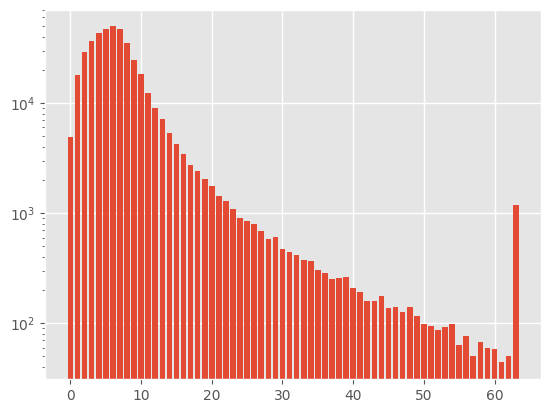

In [ ]:
import numpy as np

counts = np.bincount(table["dischtime_day"])

import matplotlib.pyplot as plt
plt.style.use("./utils/light.mplstyle")
plt.bar(range(len(counts)), counts)
plt.yscale("log")

In [ ]:
# Create group tree for attribute
n = head.get_domain(0)
group_for_x = lambda x: tuple(i == x for i in range(n))

def merge_groups(a, b):
    return tuple(i or j for i, j in zip(a, b))

class OrdNode(list):
    pass

class CatNode(list):
    pass

def create_tree(node: Level, ofs: int = 0) -> list:
    out = CatNode() if node.type == "cat" else OrdNode()

    for child in node:
        if isinstance(child, Level):
            out.append(create_tree(child, ofs))
        else:
            out.append(group_for_x(ofs))
    
        ofs += 1
    
    return out

In [ ]:
group_sizes = {}
def get_group_size(g: tuple):
    if g in group_sizes:
        return group_sizes[g]

    s = 0
    for i, present in enumerate(g):
        if present:
            s += counts[i]
    
    group_sizes[g] = s
    return s

def print_group(g: tuple):
    s = "("
    for i, present in enumerate(g):
        if present:
            s += f"{i},"
    return s[:-1] + "):" + str(get_group_size(g))

def print_tree(node: list):
    s = "[" if isinstance(node, OrdNode) else "{"
    for n in node:
        if isinstance(n, list):
            s += print_tree(n)
        else:
            s += print_group(n)
        s += ","
    s = s[:-1] + ("]" if isinstance(node, OrdNode) else "}")
    return s

print(print_tree(create_tree(head)))

[(0):4956,(1):18055,(2):29187,(3):36327,(4):43044,(5):47021,(6):49622,(7):46721,(8):34986,(9):24867,(10):18279,(11):12229,(12):9083,(13):7103,(14):5355,(15):4244,(16):3433,(17):2750,(18):2396,(19):2037,(20):1746,(21):1423,(22):1280,(23):1086,(24):911,(25):846,(26):805,(27):695,(28):579,(29):605,(30):477,(31):443,(32):414,(33):379,(34):364,(35):307,(36):286,(37):251,(38):260,(39):262,(40):210,(41):191,(42):158,(43):158,(44):177,(45):137,(46):139,(47):126,(48):141,(49):116,(50):98,(51):95,(52):87,(53):93,(54):99,(55):64,(56):76,(57):50,(58):68,(59):60,(60):58,(61):44,(62):50,(63):1188]


In [ ]:
from itertools import combinations

from pasteur.transform.attribute import get_dtype

group_sizes = {}

def merge_groups_in_node(node: list, a: tuple, b: tuple):
    tmp_node = node.copy()
    node.clear()

    for child in tmp_node:
        if child == a:
            node.append(merge_groups(a, b))
        elif child == b:
            pass
        else:
            node.append(child)

def prune_tree(tree: list):
    for i, child in enumerate(tree):
        if not isinstance(child, list):
            continue

        if len(child) == 1:
            tree[i] = child[0]
        else:
            prune_tree(child)

def find_smallest_group(parent: list):
    s_node = None
    s_a = None
    s_b = None
    s_size = -1

    # First do a recursive pass
    for child in parent:
        if isinstance(child, list):
            node, a, b, size = find_smallest_group(child)
            if s_size == -1 or size < s_size:
                s_node = node
                s_a = a
                s_b = b
                s_size = size

    # Secondly, consider children
    if isinstance(parent, OrdNode):
        # For ordinal nodes we only check nearby nodes
        for i in range(len(parent) - 1):
            a = parent[i]
            if isinstance(a, list):
                continue
            b = parent[i + 1]
            if isinstance(b, list):
                continue

            size = get_group_size(merge_groups(a, b))
            if s_size == -1 or size < s_size:
                s_node = parent
                s_a = a
                s_b = b
                s_size = size
    else:
        # For categorical nodes we check all pairs
        for i, j in combinations(range(len(parent)), 2):
            a = parent[i]
            if isinstance(a, list):
                continue
            b = parent[j]
            if isinstance(b, list):
                continue

            size = get_group_size(merge_groups(a, b))
            if s_size == -1 or size < s_size:
                s_node = parent
                s_a = a
                s_b = b
                s_size = size

    return s_node, s_a, s_b, s_size

def create_grouping(tree: list, grouping: np.ndarray, ofs: int = 0):
    for child in tree:
        if isinstance(child, tuple):
            for i, present in enumerate(child):
                if present:
                    grouping[i] = ofs
            ofs += 1
        else:
            ofs = create_grouping(child, grouping, ofs)

    return ofs
    

def make_grouping(tree: list) -> np.ndarray:
    print(f"Init: {print_tree(tree)}")

    grouping = np.empty((n-1, n), dtype=get_dtype(n))

    for i in range(1, n):
        node, a, b, _ = find_smallest_group(tree)
        merge_groups_in_node(node, a, b)
        prune_tree(tree)
        create_grouping(tree, grouping[i-1, :])
        print(f"{i:4d}: {print_tree(tree)}")
        print(grouping[i-1, :])
    return grouping


grouping = make_grouping(create_tree(head))


Init: [(0):4956,(1):18055,(2):29187,(3):36327,(4):43044,(5):47021,(6):49622,(7):46721,(8):34986,(9):24867,(10):18279,(11):12229,(12):9083,(13):7103,(14):5355,(15):4244,(16):3433,(17):2750,(18):2396,(19):2037,(20):1746,(21):1423,(22):1280,(23):1086,(24):911,(25):846,(26):805,(27):695,(28):579,(29):605,(30):477,(31):443,(32):414,(33):379,(34):364,(35):307,(36):286,(37):251,(38):260,(39):262,(40):210,(41):191,(42):158,(43):158,(44):177,(45):137,(46):139,(47):126,(48):141,(49):116,(50):98,(51):95,(52):87,(53):93,(54):99,(55):64,(56):76,(57):50,(58):68,(59):60,(60):58,(61):44,(62):50,(63):1188]
   1: [(0):4956,(1):18055,(2):29187,(3):36327,(4):43044,(5):47021,(6):49622,(7):46721,(8):34986,(9):24867,(10):18279,(11):12229,(12):9083,(13):7103,(14):5355,(15):4244,(16):3433,(17):2750,(18):2396,(19):2037,(20):1746,(21):1423,(22):1280,(23):1086,(24):911,(25):846,(26):805,(27):695,(28):579,(29):605,(30):477,(31):443,(32):414,(33):379,(34):364,(35):307,(36):286,(37):251,(38):260,(39):262,(40):210,(4

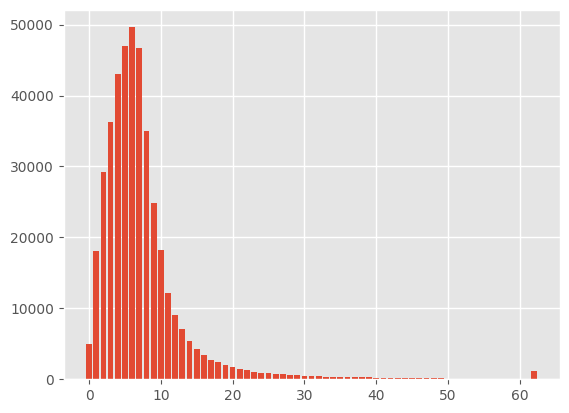

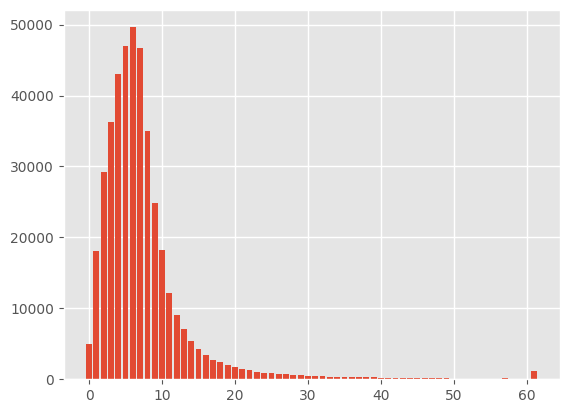

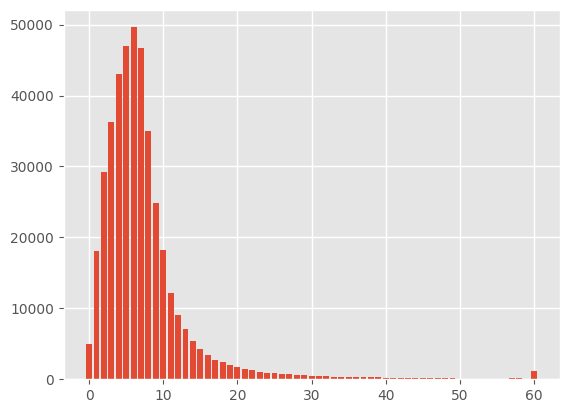

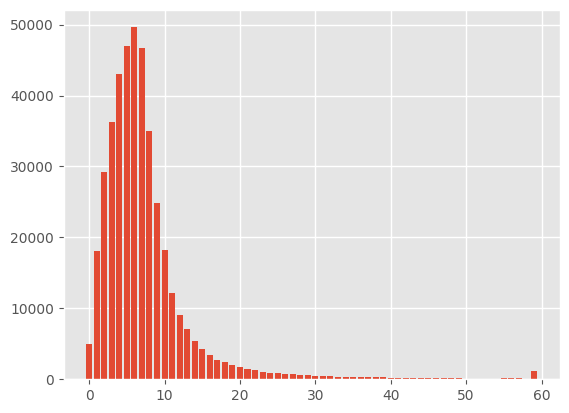

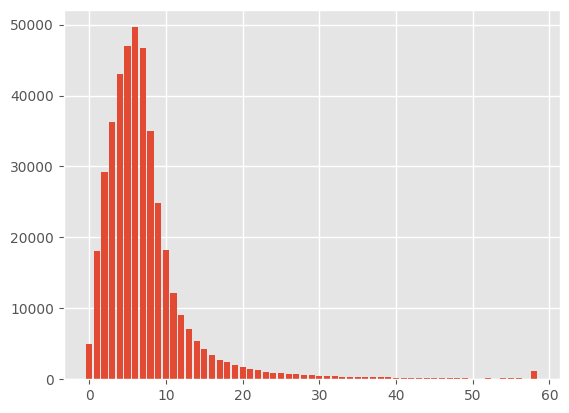

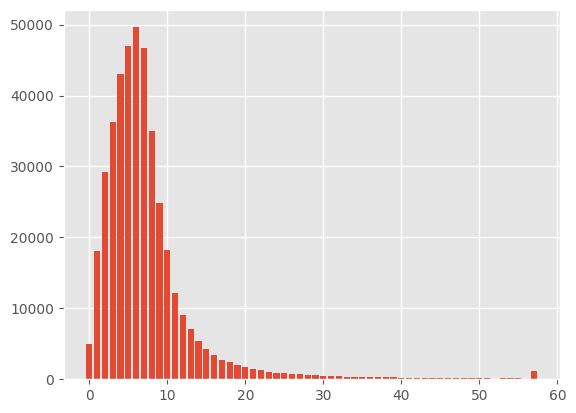

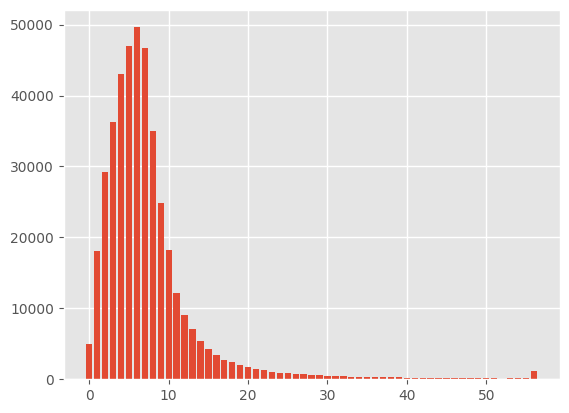

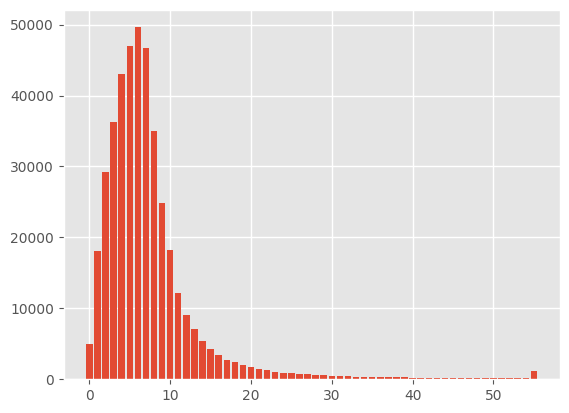

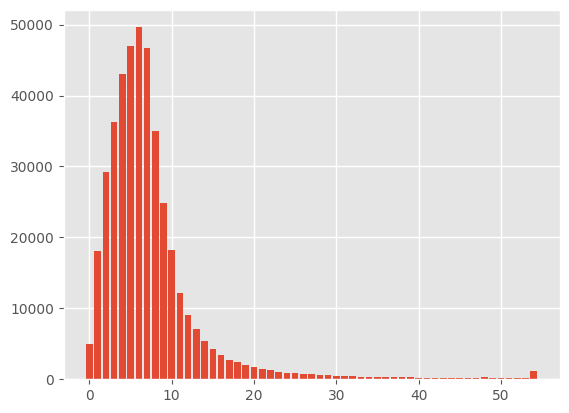

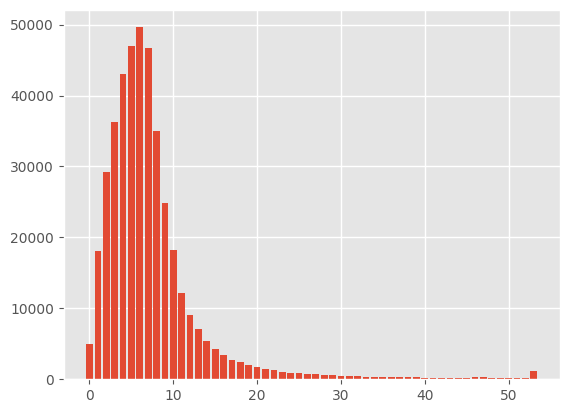

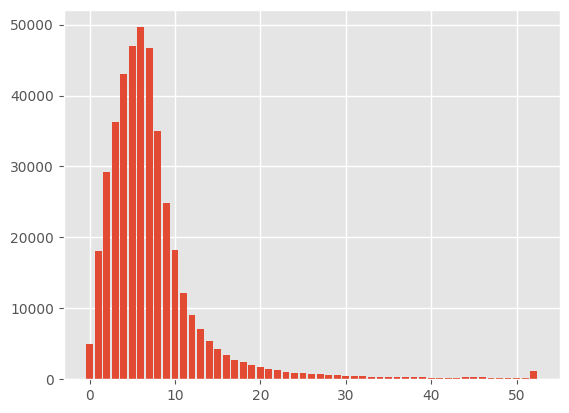

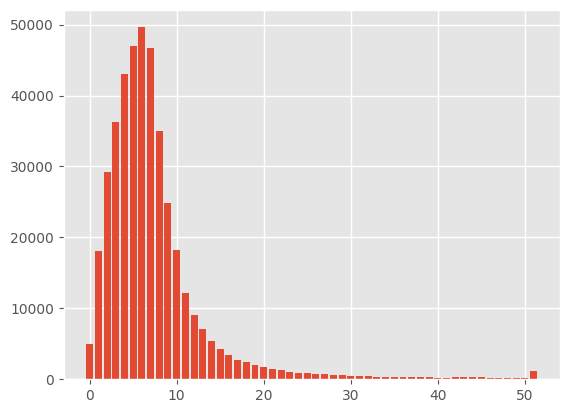

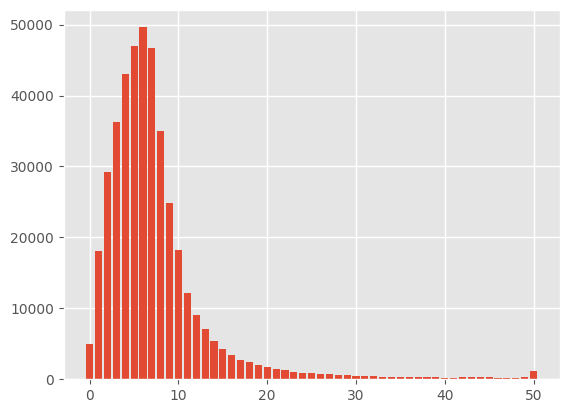

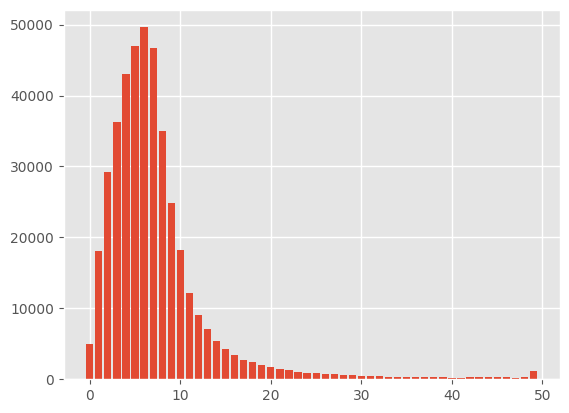

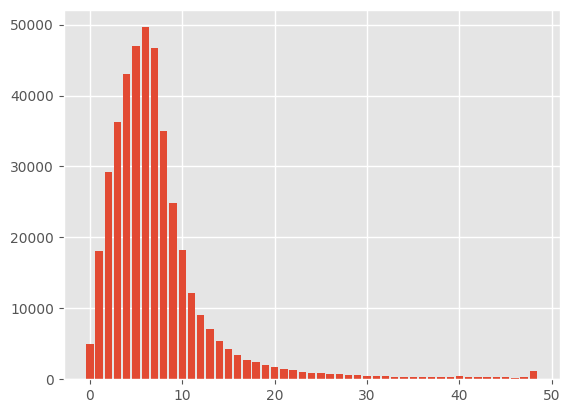

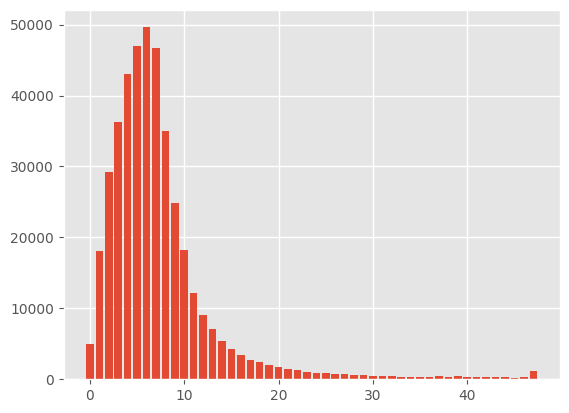

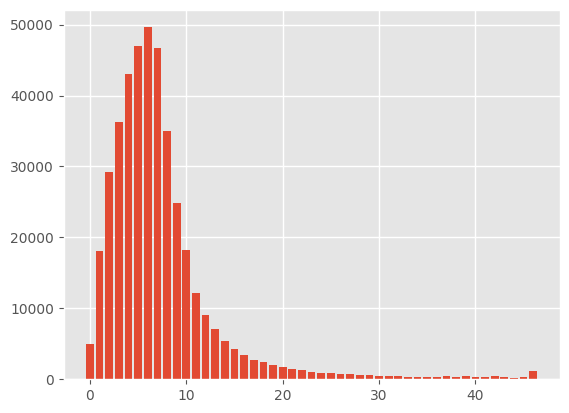

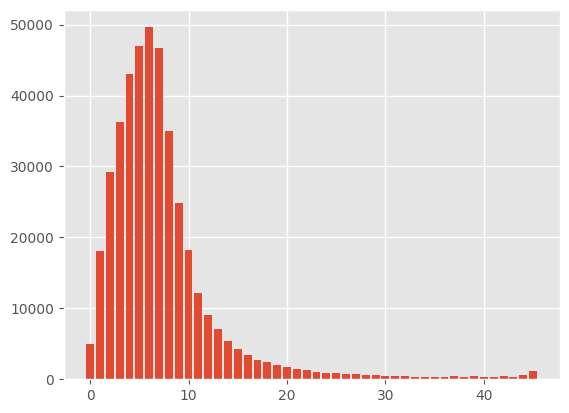

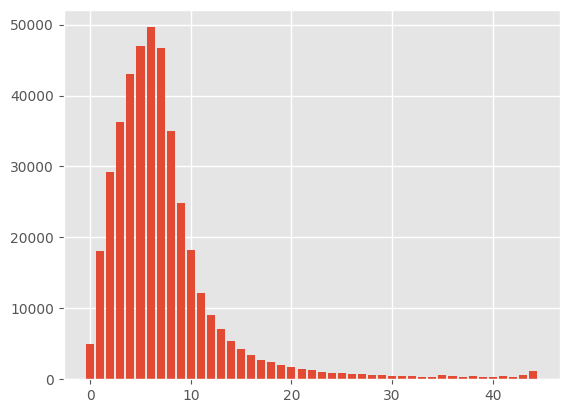

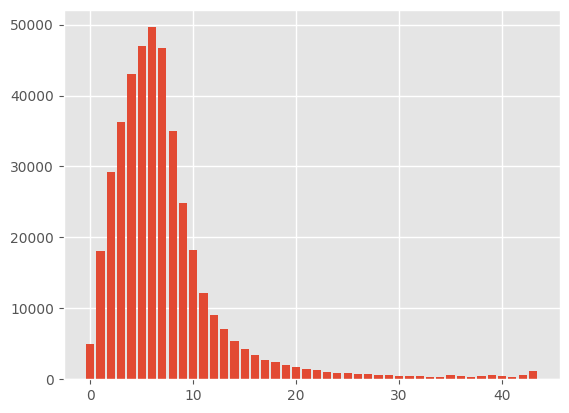

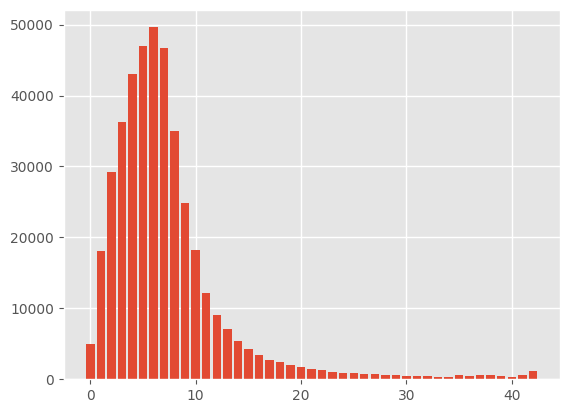

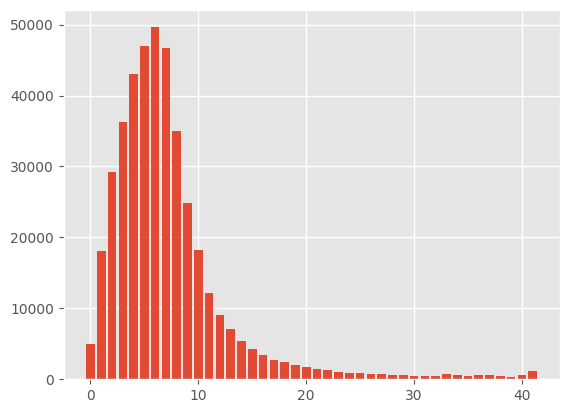

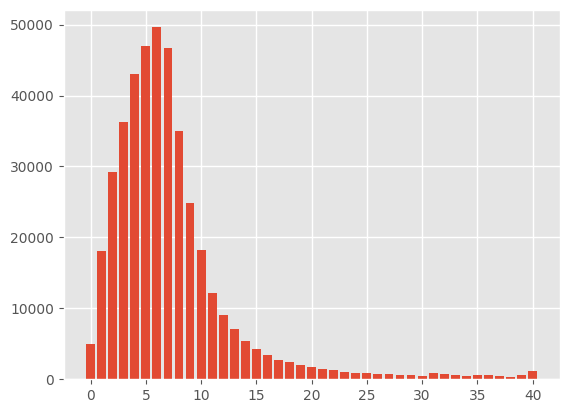

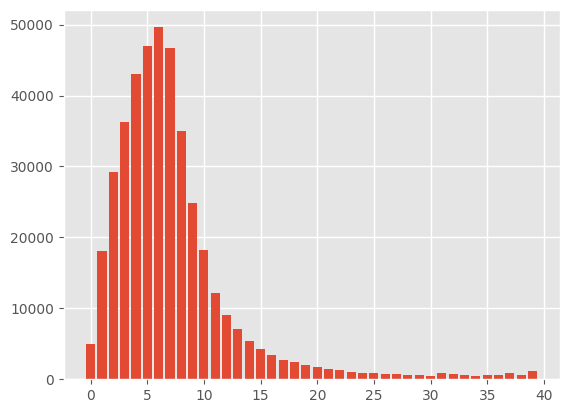

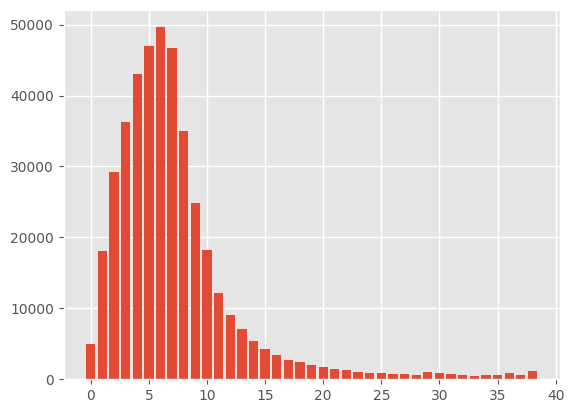

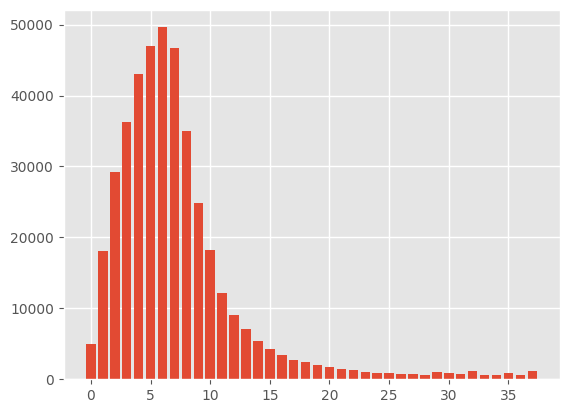

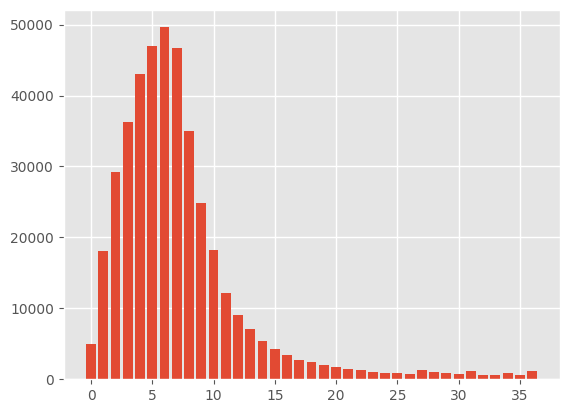

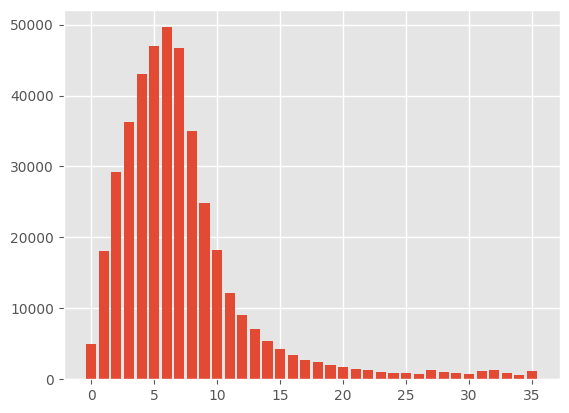

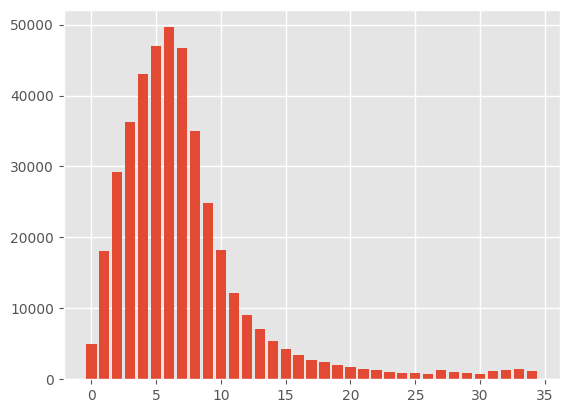

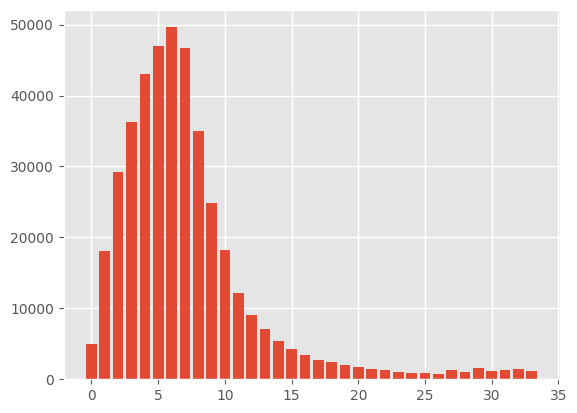

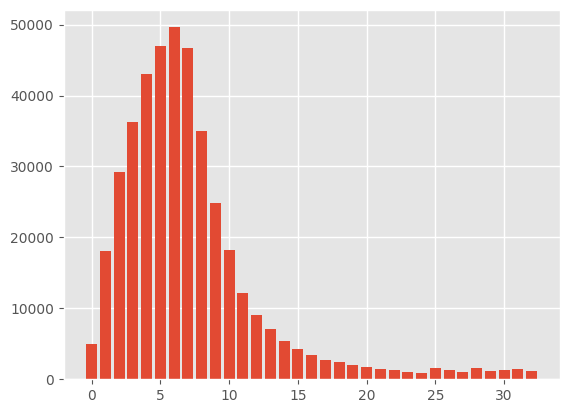

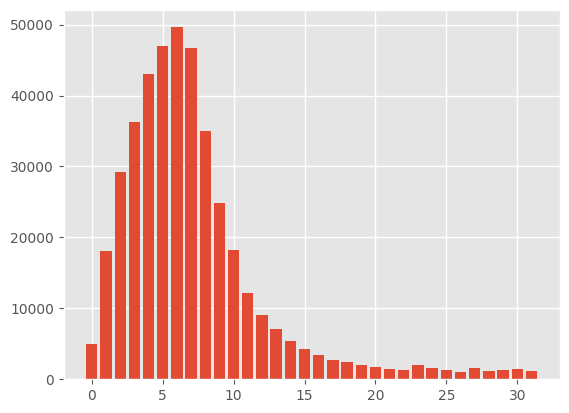

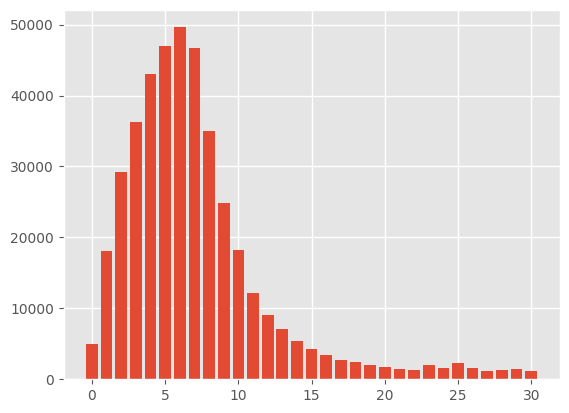

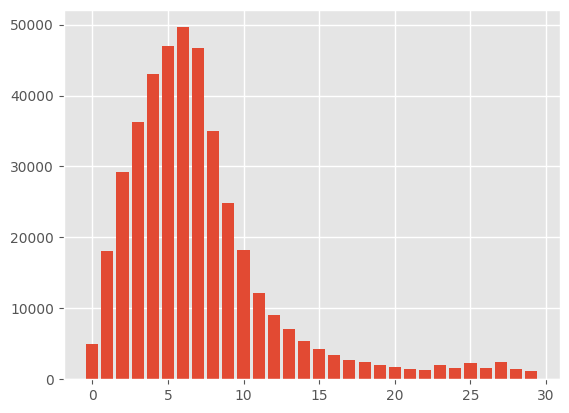

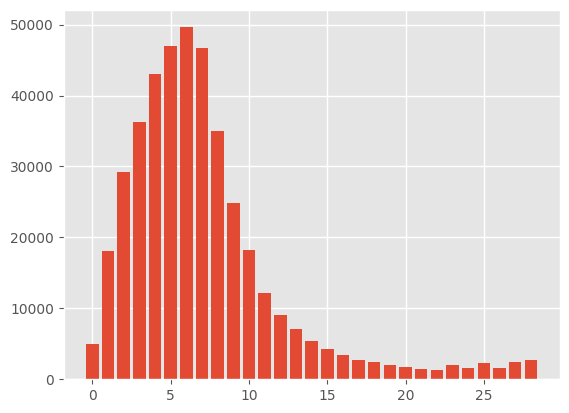

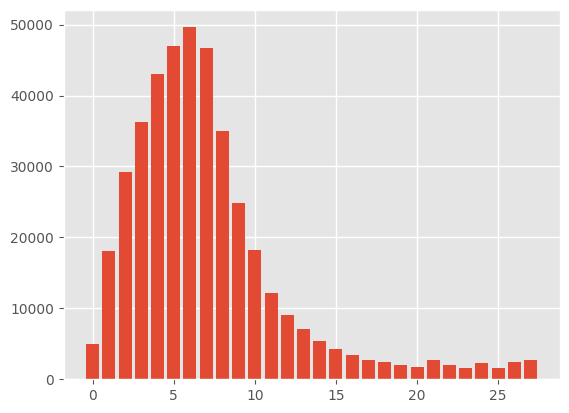

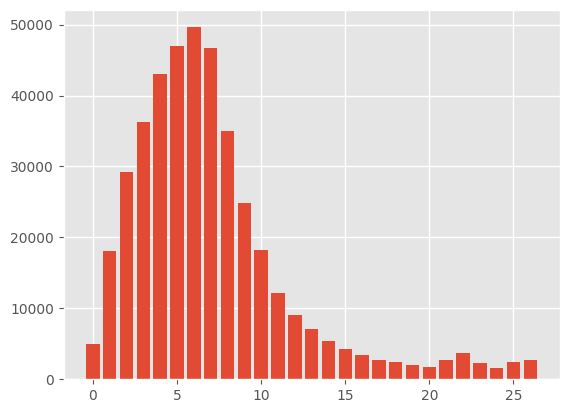

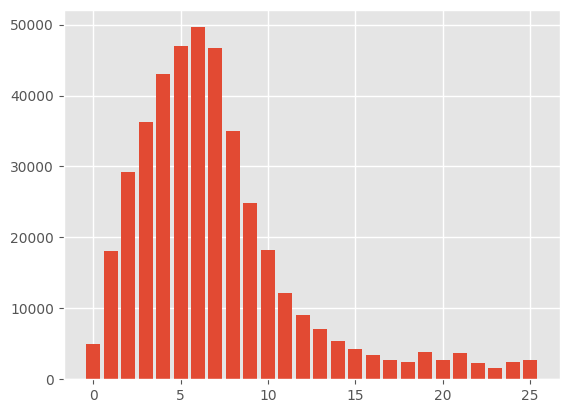

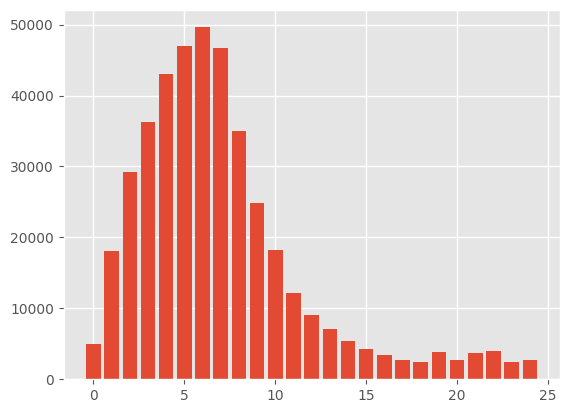

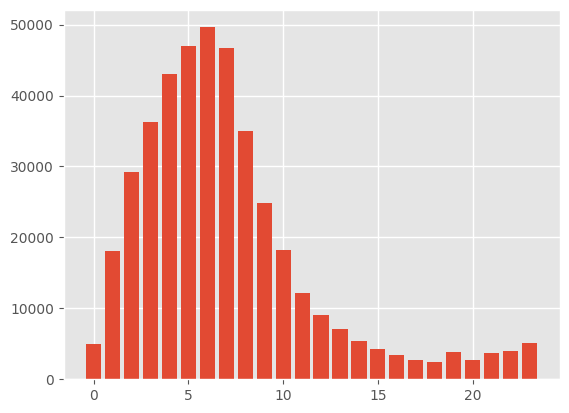

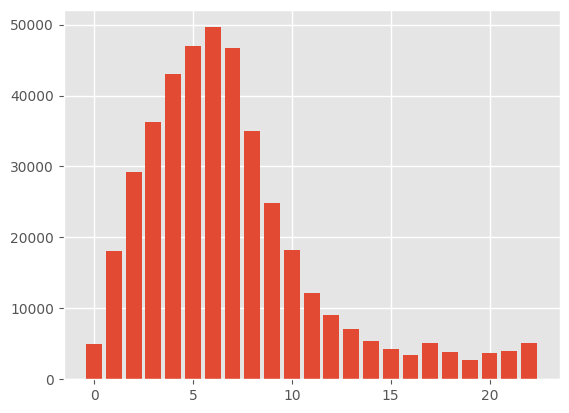

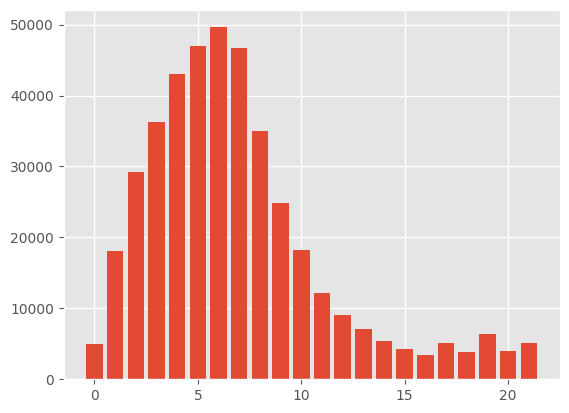

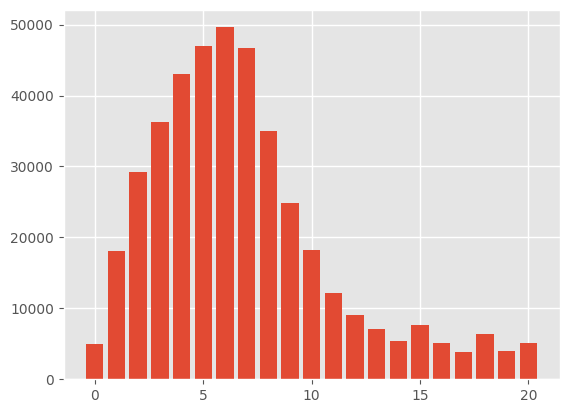

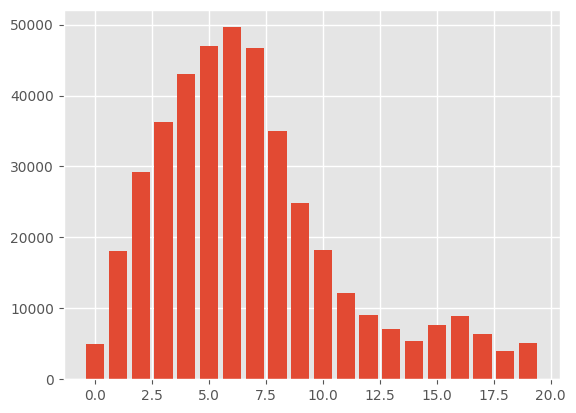

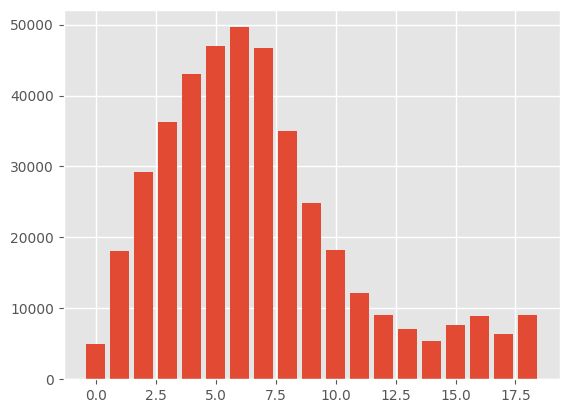

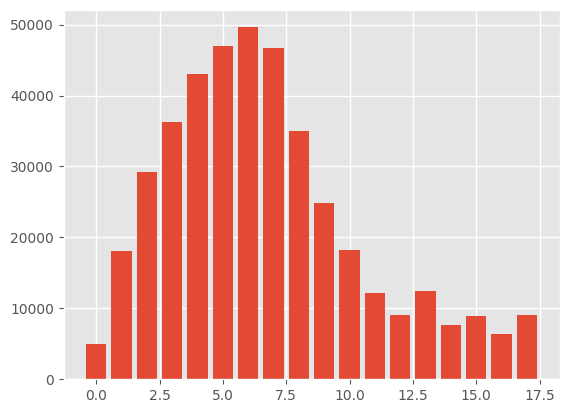

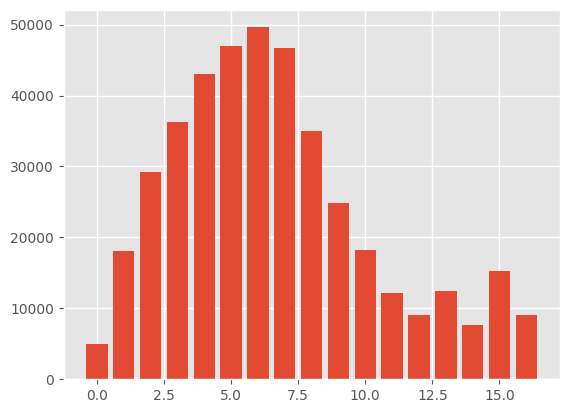

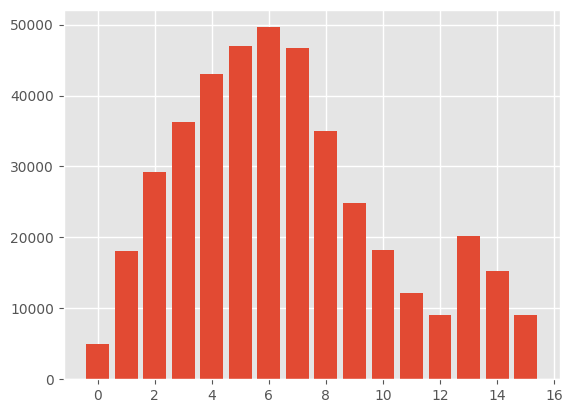

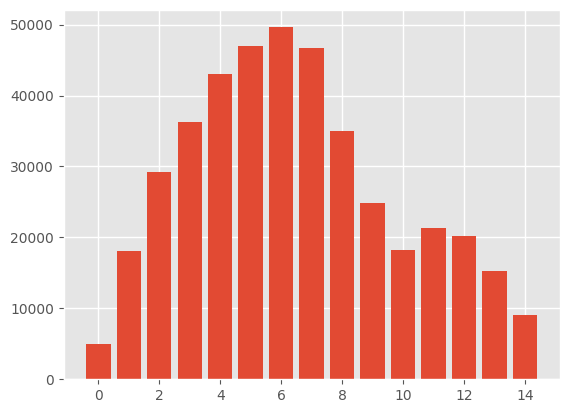

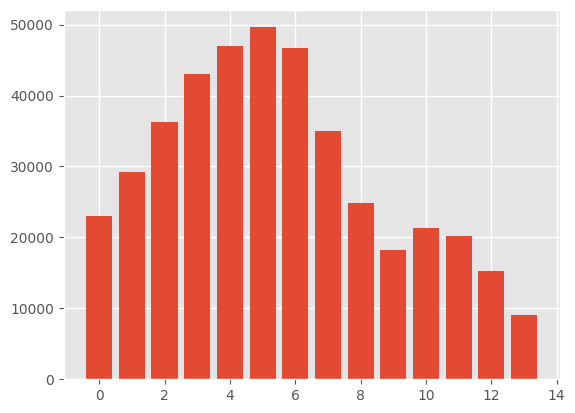

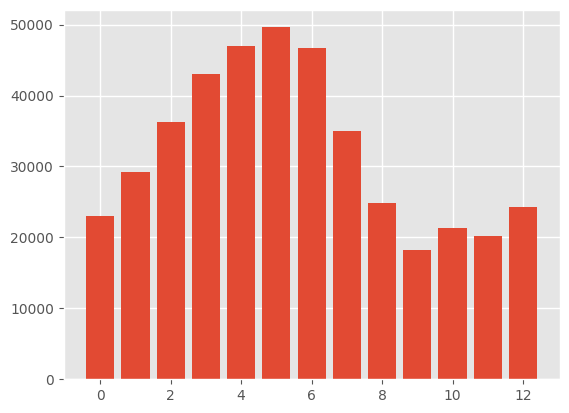

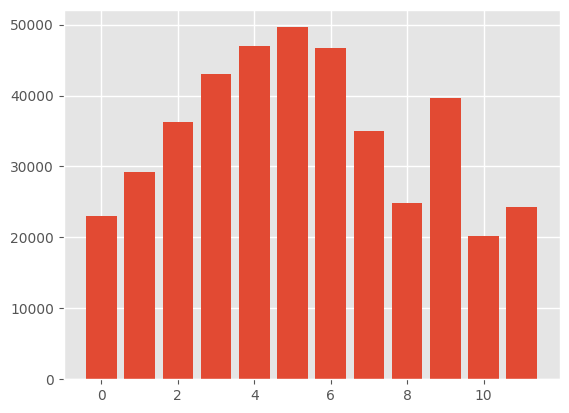

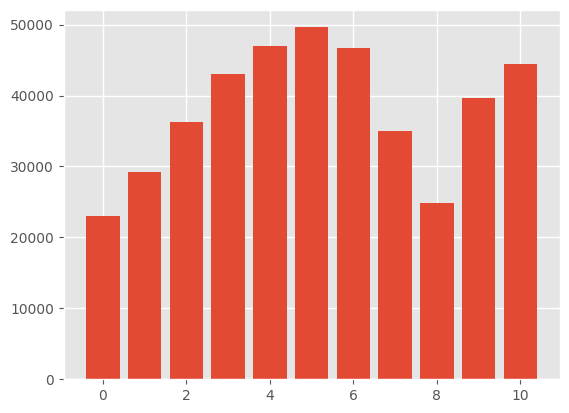

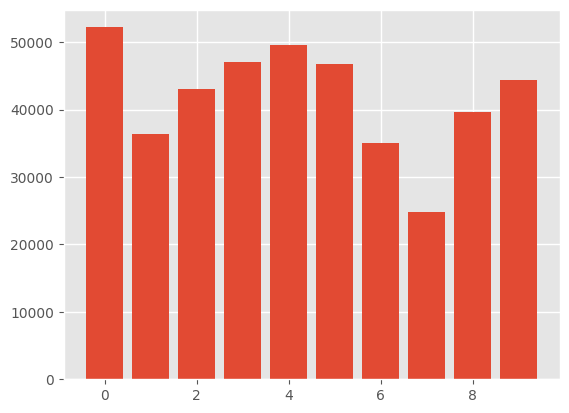

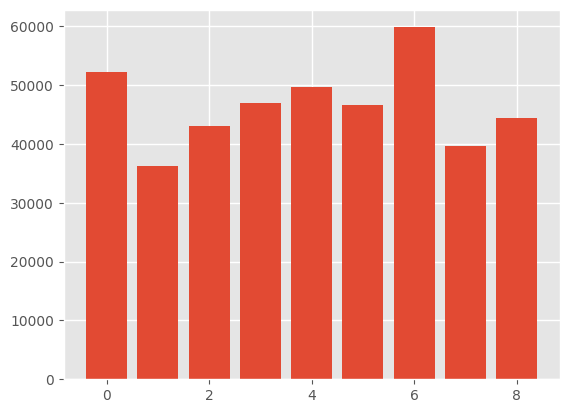

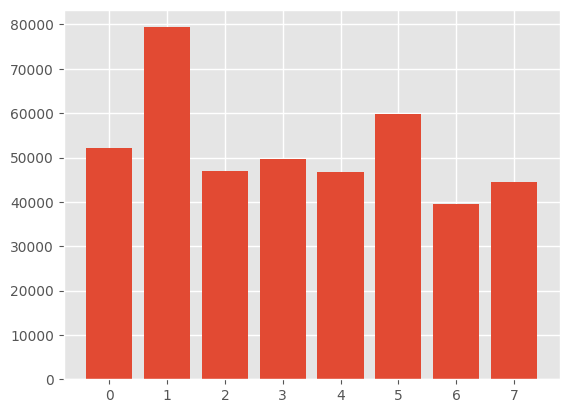

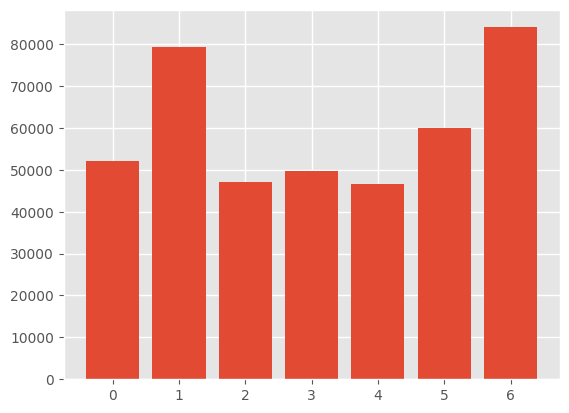

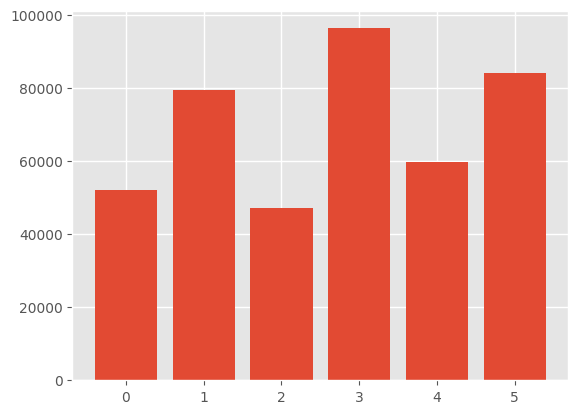

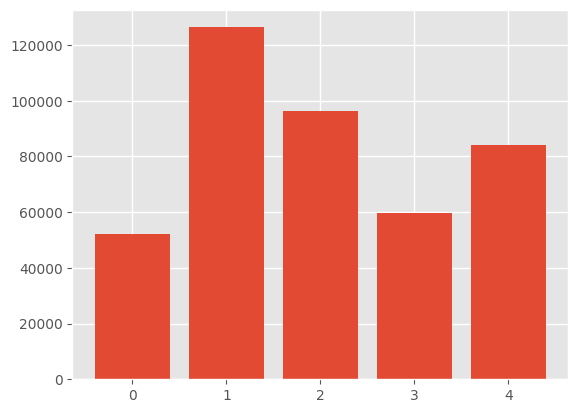

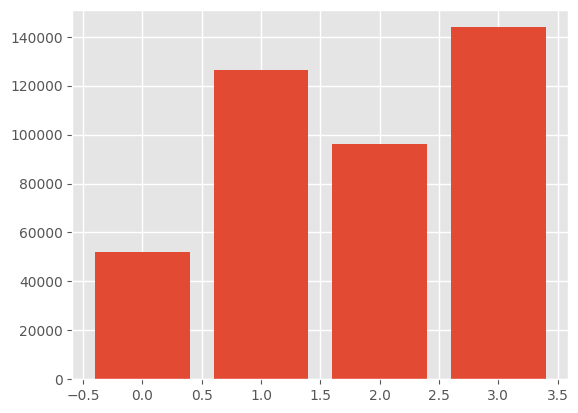

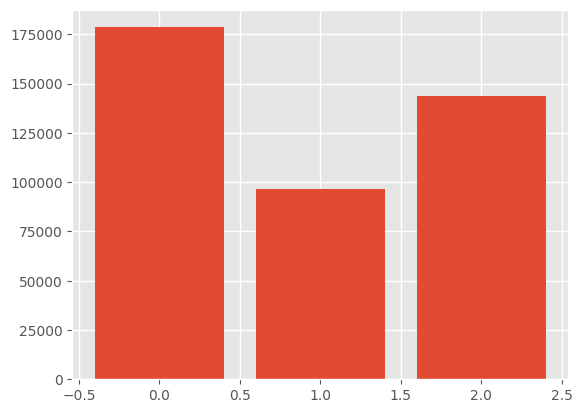

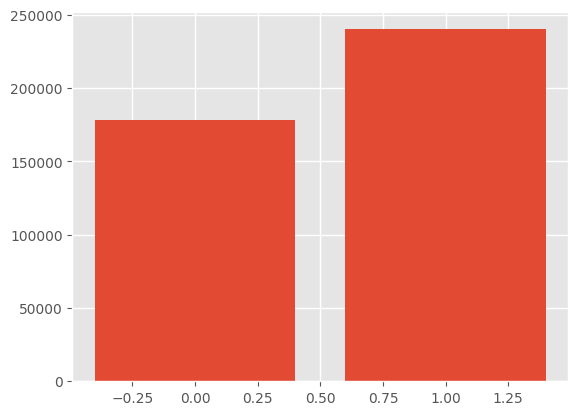

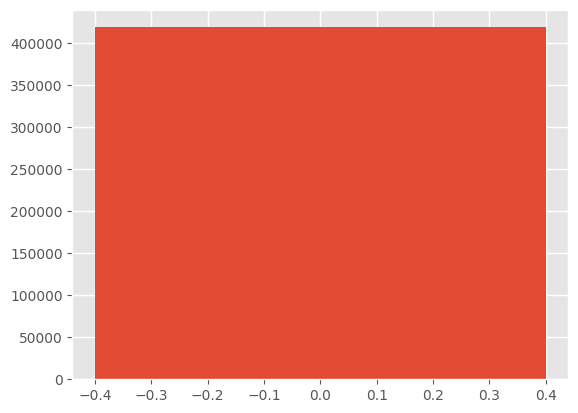

In [ ]:
for height in range(n-1):
    height_groups = grouping[height, :]
    size = len(np.unique(height_groups))

    group_counts = np.zeros((size,))
    for bucket in range(n):
        group_counts[height_groups[bucket]] += counts[bucket]
    
    plt.figure()
    plt.bar(range(size), group_counts)
    # plt.yscale("log")
